In [1]:
modelIn = "caush/Clickbait1"
                                              # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base" (accuracy=0,69)
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384" (accuracy=0,64)
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
                                              # "bert-base-cased"
problem_type =  "regression"                  # Possible values: "regression", "single_label_classification", "multi_label_classification"
num_labels = 1

dataCuratedPath = "Data/Clickbait17/Curated/" # Columns separated by ";" to avoid numeric formats nightmare:
                                              #    'postText', 'targetTitle', 'targetDescription', 'id', 'truthMean
inputColumn = 'postText'
actualOutput = 'truthMean'
computedOutput = "labelC"

removeColumns = ['postText', 'postMedia', 'targetTitle', 'id', 'truthMean']

push_to_hub = True                            # Push to Huggingface

splitFactor = 0.2                             # Part of the data for the tests
learning_rate = 5e-5
weight_decay=0.01

useExtra = True                               # Use extra set not used in the competition
phase = 2                                     # Script will be used two times

#modelSuffix = "(Labels={0} Rate={1} Decay={2} Phase={3})".format(num_labels, learning_rate, weight_decay, phase)
#modelOut = "Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=2)"
modelOut = 'caush/Clickbait2'
modelOut

'caush/Clickbait2'

In [2]:
import torch
import numpy as np

In [3]:
# Magic command to avoid locking pushtohub
!TOKENIZERS_PARALLELISM= false

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(modelIn)
model = AutoModelForSequenceClassification.from_pretrained(
   modelIn,
   problem_type=problem_type,
   num_labels = num_labels)

In [5]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elemen

In [6]:
if phase==2:
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False

    for param in model.bert.encoder.layer.parameters():
        param.requires_grad = False

In [7]:
import datasets as ds

In [8]:
curated = ds.load_from_disk(dataCuratedPath)

In [9]:
curated.to_pandas()

,postMedia,postText,targetTitle,truthMean,id
0,,"Panama Papers: Europol links 3,500 names to su...","Panama Papers: Europol links 3,500 names to su...",0.066667,804113781580328960
1,media/photo_804119509338640385.jpg,The key to truly great chicken soup,A Superior Chicken Soup,0.733333,804119512010424320
2,,Afghan policewomen face down their fears to serve,100 Women 2016: On the frontline with the wome...,0.333333,804121272967983104
3,,Conservatives are watching less football this ...,Older Viewers and Conservatives Are Watching L...,0.066667,804123103995580416
4,media/photo_804125377400553474.jpg,Richard Sherman weighs in on Cam Newton’s stru...,Seattle Seahawks Richard Sherman Says 'Karma' ...,0.133333,804126501117435904
...,...,...,...,...,...
21992,media/610200047951609857.jpg,Petition calling for Kay Burley's sacking reac...,Petition to sack Kay Burley following Alton To...,0.000000,610200047951609857
21993,media/610200274658029568.png,RT @BuzzFeedNews: This Trooper Pulled Over An ...,An Old Lady In A Scooter Was Lost On A Highway...,0.400000,610200274658029568
21994,media/610201503752658944.png,"RT @irin: No one can ever top this sentence, a...",Rich Californians balk at limits: ‘We’re not a...,0.666667,610201503752658944
21995,,VIDEO: ESPN's OTL study reveals that college a...,OTL Investigates Perception of Top College Ath...,0.200000,610201840836186112


In [10]:
if (not useExtra):
    curated=curated.filter(lambda example: example['id'].startswith('8'))

In [11]:

curated=curated.filter(lambda example: len(example['postText'])>0)

Loading cached processed dataset at Data/Clickbait17/Curated/cache-c7bda17cb22e3f38.arrow


In [12]:
longueur= len(curated)
longueur

21943

In [13]:
curatedSorted=sorted(curated[actualOutput])

In [14]:
import matplotlib.pyplot as plt

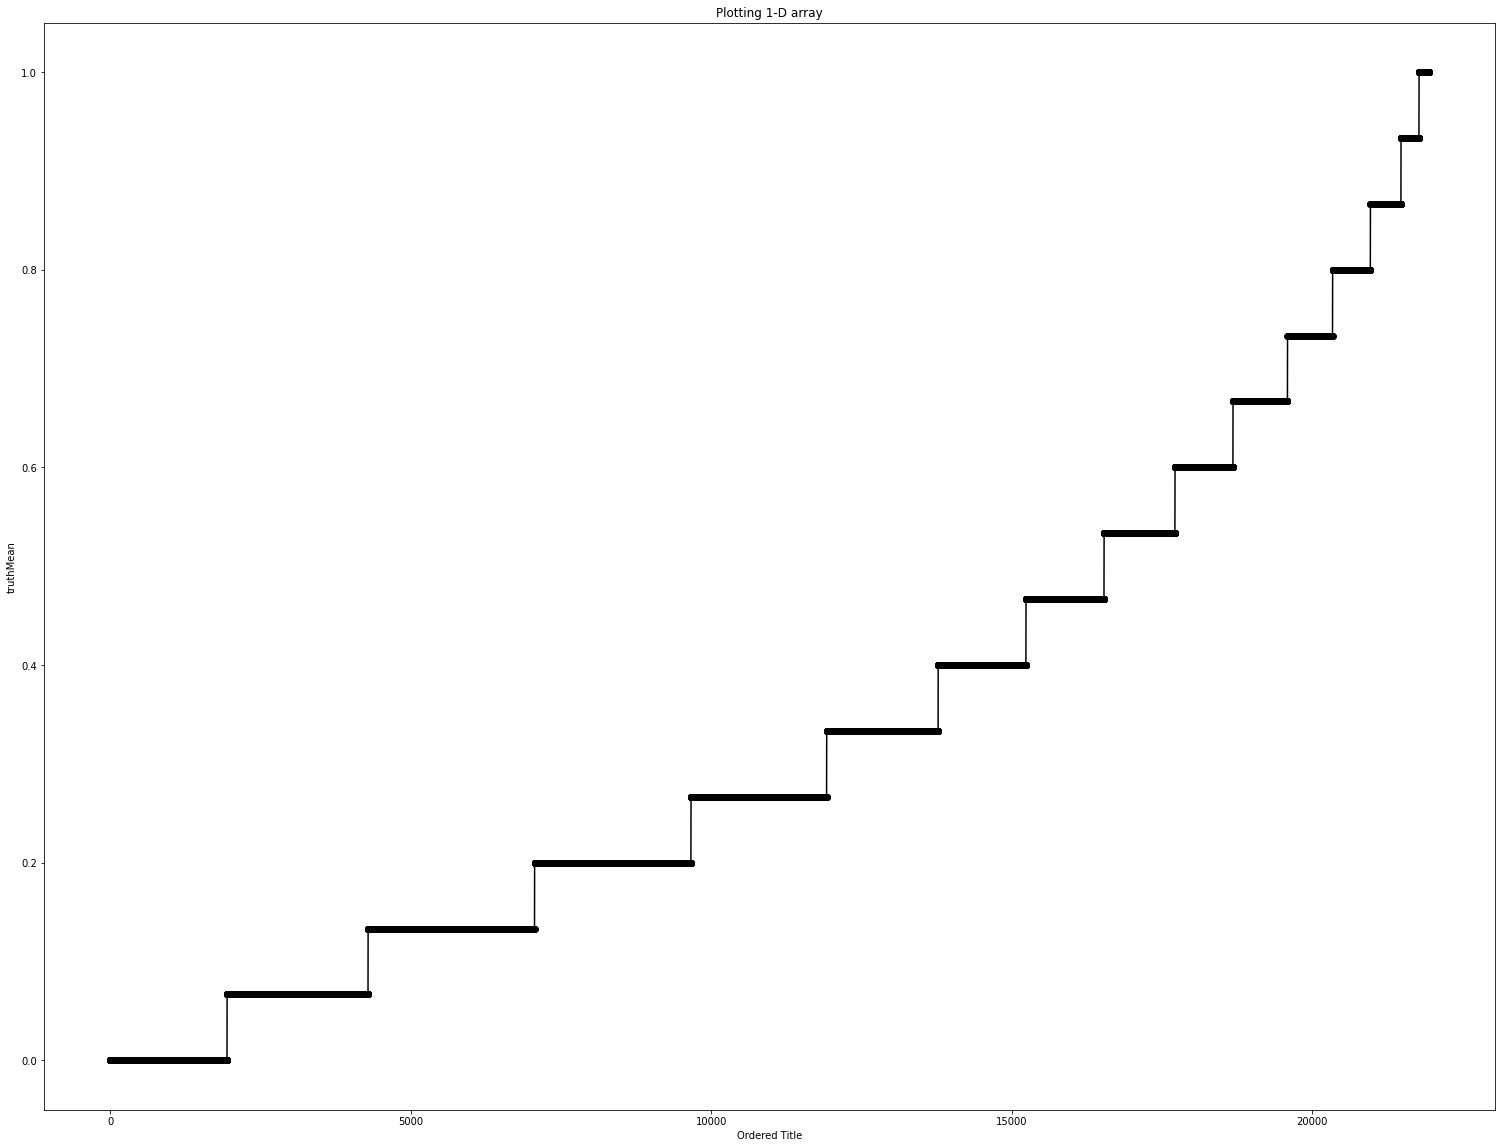

In [15]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(actualOutput)
x = np.array(range(0, longueur))
y = np.array(curatedSorted)
plt.plot(x, y, color = "black", marker = "o", label = "Array elements")

In [16]:
if num_labels > 1:
    ncf=[None] * (num_labels-1)
    for i in range(num_labels-1):
        ncf[i] = curatedSorted[longueur * (i+1) // num_labels]
    ncf

In [17]:
def tokenize(sample):
    tokenized_sample = tokenizer(sample[inputColumn])

    fraction = sample[actualOutput]
    
    if num_labels == 1:
        tokenized_sample["labels"] = fraction
    else:
        tokenized_sample["labels"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
    
    return tokenized_sample

In [18]:
tokenized_curated = curated.map(tokenize) #, batched=True)

  0%|          | 0/21943 [00:00<?, ?ex/s]

In [19]:
tokenized_curated

Dataset({
    features: ['postMedia', 'postText', 'targetTitle', 'truthMean', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 21943
})

In [20]:
tokenized_curated.to_pandas()

,postMedia,postText,targetTitle,truthMean,id,input_ids,attention_mask,labels
0,,"Panama Papers: Europol links 3,500 names to su...","Panama Papers: Europol links 3,500 names to su...",0.066667,804113781580328960,"[0, 149674, 62323, 7, 12, 3939, 5877, 22317, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.066667
1,media/photo_804119509338640385.jpg,The key to truly great chicken soup,A Superior Chicken Soup,0.733333,804119512010424320,"[0, 581, 22799, 47, 87607, 6782, 143896, 10108...","[1, 1, 1, 1, 1, 1, 1, 1, 1]",0.733333
2,,Afghan policewomen face down their fears to serve,100 Women 2016: On the frontline with the wome...,0.333333,804121272967983104,"[0, 57351, 1121, 35206, 3613, 1055, 2577, 7565...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.333333
3,,Conservatives are watching less football this ...,Older Viewers and Conservatives Are Watching L...,0.066667,804123103995580416,"[0, 78771, 42991, 621, 100244, 40715, 101740, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.066667
4,media/photo_804125377400553474.jpg,Richard Sherman weighs in on Cam Newton’s stru...,Seattle Seahawks Richard Sherman Says 'Karma' ...,0.133333,804126501117435904,"[0, 22758, 53257, 669, 642, 6958, 7, 23, 98, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
...,...,...,...,...,...,...,...,...
21938,media/610200047951609857.jpg,Petition calling for Kay Burley's sacking reac...,Petition to sack Kay Burley following Alton To...,0.000000,610200047951609857,"[0, 75362, 1830, 159029, 100, 26125, 7362, 429...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000
21939,media/610200274658029568.png,RT @BuzzFeedNews: This Trooper Pulled Over An ...,An Old Lady In A Scooter Was Lost On A Highway...,0.400000,610200274658029568,"[0, 27389, 1374, 7235, 13894, 30154, 297, 2241...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.400000
21940,media/610201503752658944.png,"RT @irin: No one can ever top this sentence, a...",Rich Californians balk at limits: ‘We’re not a...,0.666667,610201503752658944,"[0, 27389, 1374, 41503, 12, 438, 1632, 831, 17...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.666667
21941,,VIDEO: ESPN's OTL study reveals that college a...,OTL Investigates Perception of Top College Ath...,0.200000,610201840836186112,"[0, 14483, 12, 57898, 839, 25, 7, 180, 41445, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000


In [21]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2

In [22]:
tokenized_curated2['train'].to_pandas()

,postMedia,postText,targetTitle,truthMean,id,input_ids,attention_mask,labels
0,,The state shouldn't be helping itself to our c...,The state shouldn't be helping itself to our c...,0.133333,850840682524811264,"[0, 581, 11341, 5608, 19, 25, 18, 186, 120592,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
1,,acts of love.,Illegal Immigrant Accused of Repeatedly Raping...,0.733333,854781182017404928,"[0, 27992, 7, 111, 5161, 5, 2]","[1, 1, 1, 1, 1, 1, 1]",0.733333
2,media/photo_833881434037354497.jpg,California police officer shot dead after resp...,Cops: Calif. officer responding to traffic acc...,0.000000,833881437912838145,"[0, 39897, 35206, 93324, 51876, 103494, 7103, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.000000
3,media/photo_851728782184652800.jpg,Getting a puppy while you're pregnant could ha...,Getting a Puppy While You’re Pregnant Could Ha...,0.400000,851728784353103872,"[0, 210732, 10, 207109, 12960, 398, 25, 107, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.400000
4,,Opposition to Trump travel ban grows as key co...,Federal appeals court decides to schedule a he...,0.000000,828633613163970561,"[0, 2331, 40322, 47, 5879, 26983, 4599, 55993,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.000000
...,...,...,...,...,...,...,...,...
17549,media/photo_858363330146164736.jpg,NFL commissioner Roger Goodell believes mariju...,NFL Commissioner Roger Goodell Believes Mariju...,0.066667,858363332398600192,"[0, 186831, 62458, 56, 48861, 18621, 6796, 188...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.066667
17550,,"""Oh, you’re a teacher, you paint all day?"" Not...","‘Oh, you’re a teacher, you paint all day?’ Not...",0.800000,608315598486011905,"[0, 44, 56886, 4, 398, 26, 107, 10, 117914, 4,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.800000
17551,media/photo_830073867028877312.jpg,A clue as to what Rosie O'Donnell's Steve Bann...,Rosie O'Donnell offers glimpse at what she'd l...,0.466667,830073870086438913,"[0, 62, 6, 29786, 13, 237, 47, 2367, 12015, 47...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.466667
17552,media/photo_834471399234244608.jpg,Rockets have reportedly expressed interest in ...,Iman Shumpert Reportedly a Trade Target for Ro...,0.000000,834471551487590400,"[0, 14434, 7831, 765, 113771, 538, 36510, 297,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000


In [23]:
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [24]:
tokenized_curated4 = tokenized_curated3

In [25]:
tokenized_curated4

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 17554
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4389
    })
})

In [26]:
from transformers import TrainingArguments

In [27]:
training_args = TrainingArguments(modelOut,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation happens every 50 steps
                                  save_steps = 50, # Save happens every 50 steps
                                  save_total_limit = 10, # Only last 10 models are saved. Older ones are deleted.
                                  num_train_epochs = 4,
                                  optim= 'adamw_torch',
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16,
                                  learning_rate=learning_rate,
                                  weight_decay=weight_decay,
                                  #push_to_hub=push_to_hub,
                                  #hub_strategy='end', # finished
                                  load_best_model_at_end=True
                                 )

In [28]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [29]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=10)],
                 )

Main training loop

In [30]:
!TOKENIZERS_PARALLELISM= false

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
if (modelIn != modelOut):
    trainer.train()

***** Running training *****
  Num examples = 17554
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4392


Step,Training Loss,Validation Loss
50,No log,0.021332
100,No log,0.021331
150,No log,0.021317
200,No log,0.021633
250,No log,0.021356
300,No log,0.021202
350,No log,0.021428
400,No log,0.021205
450,No log,0.021794
500,0.021900,0.021946


***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
Saving model checkpoint to caush/Clickbait2/checkpoint-50
Configuration saved in caush/Clickbait2/checkpoint-50/config.json
Model weights saved in caush/Clickbait2/checkpoint-50/pytorch_model.bin
tokenizer config file saved in caush/Clickbait2/checkpoint-50/tokenizer_config.json
Special tokens file saved in caush/Clickbait2/checkpoint-50/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
Saving model checkpoint to caush/Clickbait2/checkpoint-100
Configuration saved in caush/Clickbait2/checkpoint-100/config.json
Model weights saved in caush/Clickbait2/checkpoint-100/pytorch_model.bin
tokenizer config file saved in caush/Clickbait2/checkpoint-100/tokenizer_config.json
Special tokens file saved in caush/Clickbait2/checkpoint-100/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
Saving model checkpoint to caush/Clickbait2/checkpoint

In [32]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16


{'eval_loss': 0.021201925352215767,
 'eval_runtime': 3.6643,
 'eval_samples_per_second': 1197.777,
 'eval_steps_per_second': 75.049,
 'epoch': 0.73}

In [33]:
# Save model on disk
if (modelIn != modelOut):
    model.save_pretrained(modelOut)

Configuration saved in caush/Clickbait2/config.json
Model weights saved in caush/Clickbait2/pytorch_model.bin


In [34]:
if (modelIn != modelOut):
    tokenizer.save_vocabulary(modelOut)

In [35]:
if push_to_hub:
    trainer.push_to_hub()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/notebooks/caush/Clickbait2 is already a clone of https://huggingface.co/caush/Clickbait2. Make sure you pull the latest changes with `repo.git_pull()`.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to caush/Clickbait2
Configuration saved in caush/Clickbait2/config.json
Model weights saved in caush/Clickbait2/pytorch_model.bin
tokenizer config file saved in caush/Clickbait2/tokenizer_config.json
Special tokens file saved in caush/Clickbait2/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 32.0k/449M [00:00<?, ?B/s]

Upload file runs/Apr26_21-08-10_np1ue5ju3f/1651007301.5151894/events.out.tfevents.1651007301.np1ue5ju3f.1639.1…

Upload file runs/Apr26_21-08-10_np1ue5ju3f/events.out.tfevents.1651007301.np1ue5ju3f.1639.0: 100%|##########| …

Upload file runs/Apr26_21-08-10_np1ue5ju3f/events.out.tfevents.1651007457.np1ue5ju3f.1639.2: 100%|##########| …

Upload file training_args.bin: 100%|##########| 2.98k/2.98k [00:00<?, ?B/s]

To https://huggingface.co/caush/Clickbait2
   18d7f27..e0ce508  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/caush/Clickbait2
   e0ce508..28940b1  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some extra. Displaying the results.

In [36]:
# Just to see if we are overfitting. Draw the graph with training set
overfitting = "test" #  "train" # "test"

In [37]:
model.to(torch.device("cuda:0"))
predictions = trainer.predict(tokenized_curated2[overfitting])

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: postMedia, truthMean, targetTitle, postText, id. If postMedia, truthMean, targetTitle, postText, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4389
  Batch size = 16


In [38]:
predictions.metrics

{'test_loss': 0.021201925352215767,
 'test_runtime': 4.4693,
 'test_samples_per_second': 982.044,
 'test_steps_per_second': 61.532}

In [39]:
tct = tokenized_curated2[overfitting].to_pandas()

In [40]:
if num_labels == 1:
    tct[computedOutput] = predictions.predictions
else:
    tct[computedOutput] = np.argmax(predictions.predictions, axis=1)   

In [41]:
tct1 = tct.sort_values([actualOutput, computedOutput])
tct2 = tct.sort_values([computedOutput,actualOutput] )

In [42]:
if num_labels == 1:
    color1 = [val for val in tct1[computedOutput]]
    color2 = [val for val in tct1[actualOutput]]
else:
    palette = ["r", "g", "b", "c", "m"]
    color1 = [palette[val] for val in tct1[computedOutput]]
    color2 = [palette[val] for val in tct1[actualOutput]]

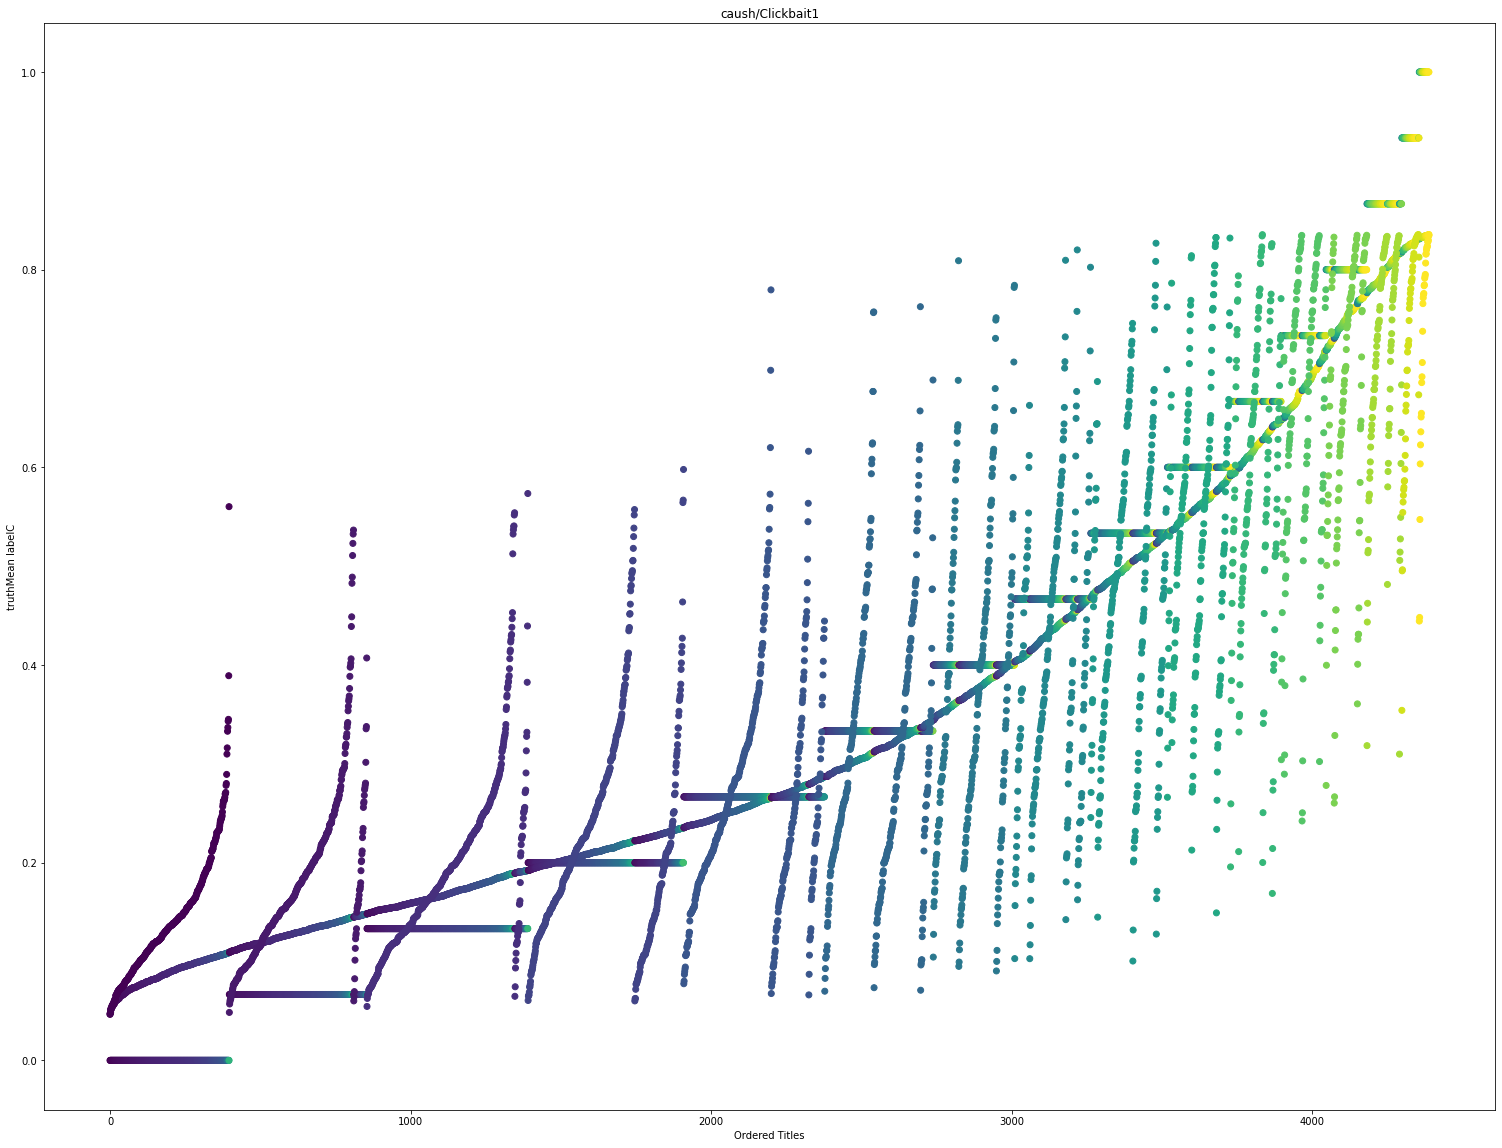

In [43]:
plt.figure(figsize=(26, 20))
plt.title(modelIn)
plt.xlabel("Ordered Titles")

plt.ylabel(actualOutput + " " + computedOutput)

x = np.array(range(0, tct1.shape[0]))
y = tct1[actualOutput]
plt.scatter(x, y, c = color1, marker = "o", label = "Array elements")

x2 = np.array(range(0, tct2.shape[0]))
y2 = tct2[computedOutput]
plt.scatter(x2, y2, c = color1, marker = "o", label = "Array elements")

x3 = np.array(range(0, tct1.shape[0]))
y3 = tct1[computedOutput]
plt.scatter(x3, y3, c = color2, marker = "o", label = "Array elements")


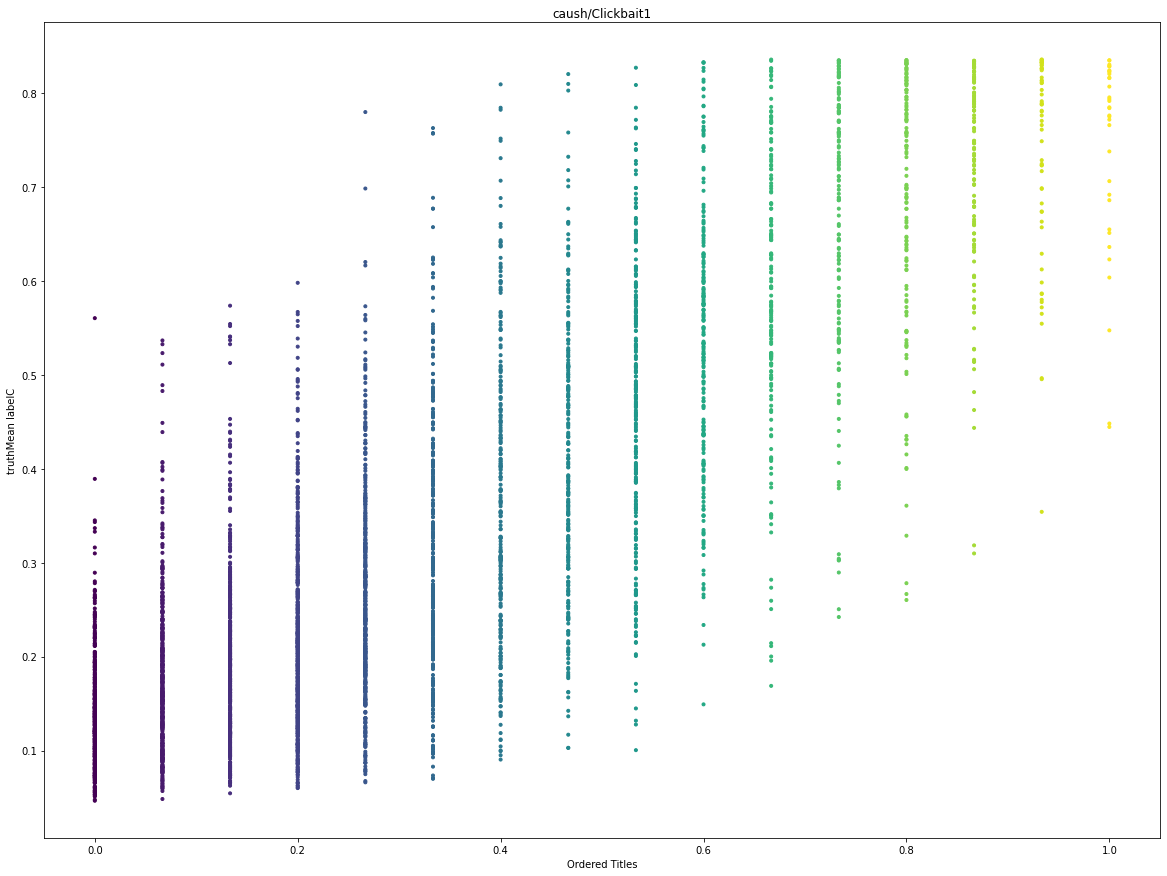

In [44]:
plt.figure(figsize=(20, 15))
plt.title(modelIn)
plt.xlabel("Ordered Titles")

plt.ylabel(actualOutput + " " + computedOutput)

x = np.array(range(0, tct1.shape[0]))
y = tct1[actualOutput]
# plt.scatter(x, y, c = color1, marker = "o", label = "Array elements")

x2 = np.array(range(0, tct2.shape[0]))
y2 = tct2[computedOutput]
# plt.scatter(x2, y2, c = color1, marker = "o", label = "Array elements")

x3 = tct1[actualOutput]
y3 = tct1[computedOutput]
plt.scatter(x3, y3, c = color2, marker = ".", label = "Array elements")

In [45]:
tct[[computedOutput, actualOutput]].describe()

,labelC,truthMean
count,4389.000000,4389.000000
mean,0.333396,0.332179
std,0.209352,0.253085
min,0.046685,0.000000
25%,0.165646,0.133333
50%,0.265071,0.266667
75%,0.476788,0.533333
max,0.835565,1.000000


In [46]:
tct.corr()

,truthMean,labels,labelC
truthMean,1.000000,1.000000,0.817938
labels,1.000000,1.000000,0.817938
labelC,0.817938,0.817938,1.000000
